In [ ]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from PIL import Image
# import tensorflow as tf
from sklearn import decomposition
import cv2
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
LABELS =  ['call_me', 'fingers_crossed', 'okay', 'paper', 'peace', 'rock', 'rock_on', 'scissor', 'thumbs', 'up']
LABELS_TO_INDEX = {k: v for v, k in enumerate(LABELS)}
INDEX_TO_LABELS = {k: v for k, v in enumerate(LABELS)}

In [7]:
# if no dataset folder, extract it and it only runs on colab
if not os.path.exists('datasets/'):
    !unzip -q datasets.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
images = []
train_labels = []
for label_name in LABELS:
    folder_path = 'datasets/HandGesture/images/' + label_name
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))
        if img.mode != 'L':
            img = img.convert('L')
        img_arr = np.array(img)
        images.append(img_arr)
        train_labels.append(label_name)
images = np.array(images)
print(images.shape)

(5243, 195, 240)


In [5]:
img_shape = images[0].shape                         # 195 x 240
X = images.reshape(images.shape[0], -1)             # flatten 195 x 240 image
y = np.vectorize(LABELS_TO_INDEX.get)(train_labels) # convert label name to index (call_me -> 0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (3670, 46800)
y_train (3670,)
X_test (1573, 46800)
y_test (1573,)


# Feature Extraction using PCA

In [7]:
standardized_scalar = StandardScaler()
standardized_data = standardized_scalar.fit_transform(X)
standardized_data.shape

(5243, 46800)

In [8]:
# cov_matrix = np.matmul(standardized_data.T, standardized_data)
# cov_matrix.shape

In [10]:
# Warning: this takes 6 minutes to run
pca = decomposition.PCA(n_components = 980) # 95% of variance
principal_components = pca.fit_transform(standardized_data)

In [11]:
print('Total Variance:', sum(pca.explained_variance_ratio_))
print('Number of Components:', pca.n_components_)
print(principal_components.shape)

Total Variance: 0.9527581823542743
Number of Components: 980
(5243, 980)


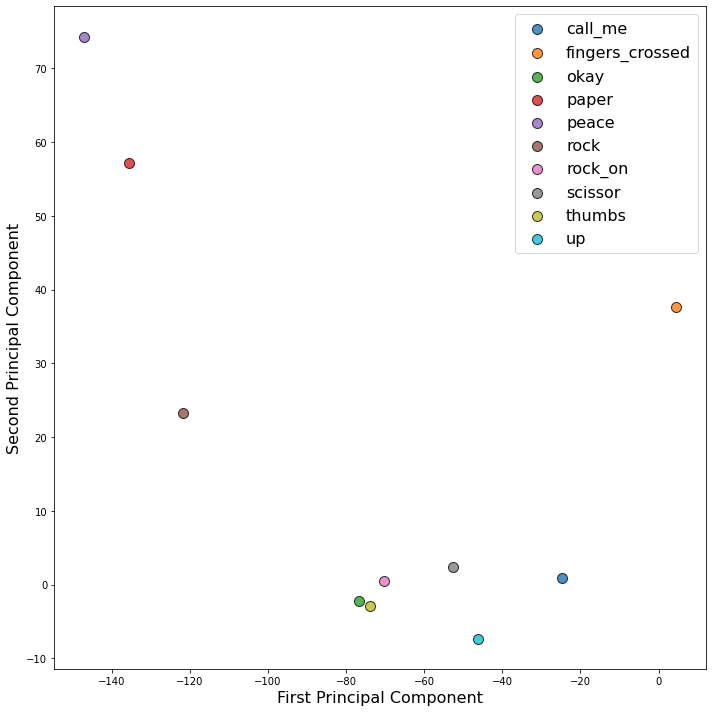

In [12]:
plt.figure(figsize=(10, 10))

colors = plt.cm.tab10(np.linspace(0, 1, len(LABELS)))

for label, color in zip(LABELS, colors):
    indices = [i for i, l in enumerate(LABELS) if l == label]
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1], 
                c=[color], label=label, edgecolors='k', alpha=0.8, s=100)

plt.xlabel('First Principal Component', fontsize='16')
plt.ylabel('Second Principal Component', fontsize='16')
plt.legend(loc='best', fontsize='16')
plt.tight_layout()
plt.show()

# Feature Extration with HOG

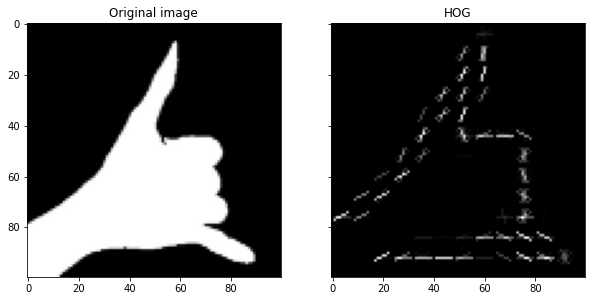

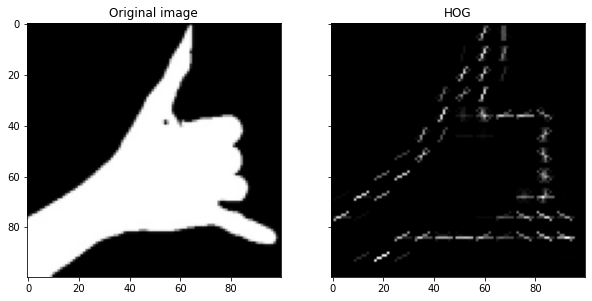

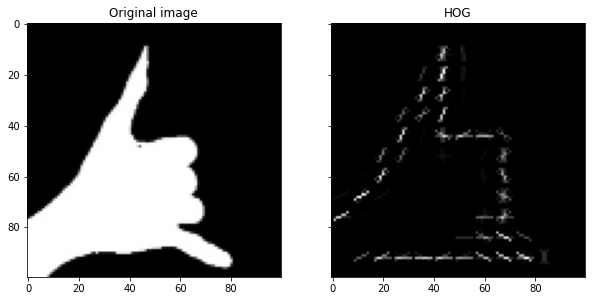

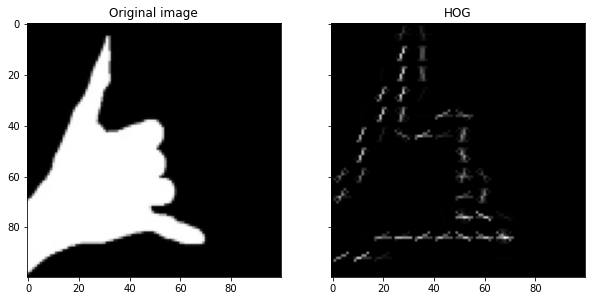

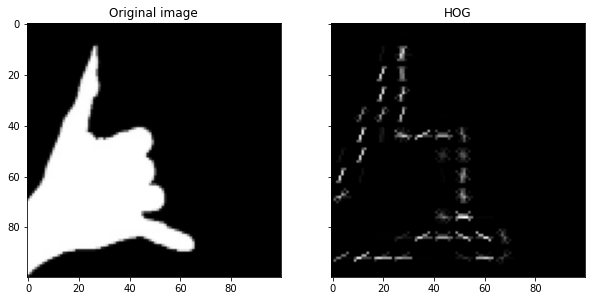

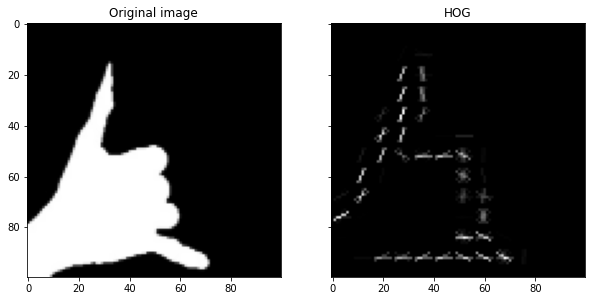

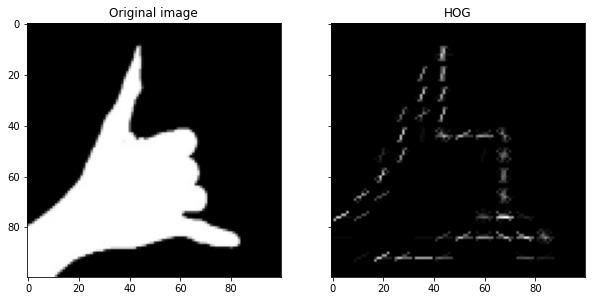

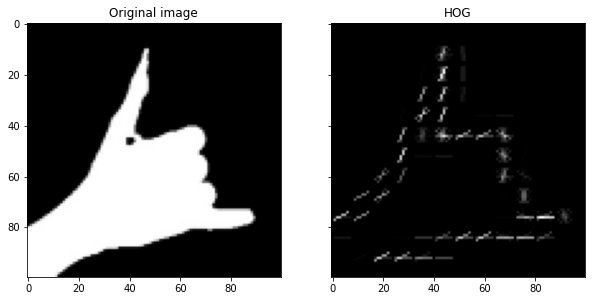

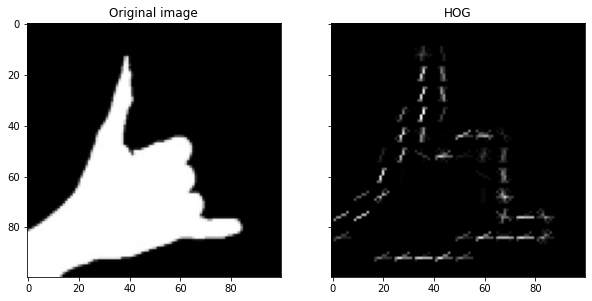

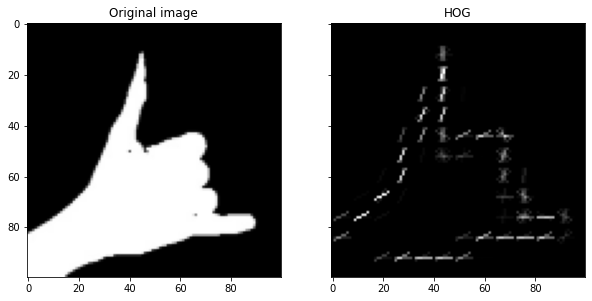

In [13]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
import io


fds = []
hog_img_list = []
ori_img_list = []

max_hog_display = 10  # Display 10 HOG images, change it if different number of HOG images is desired
count = 0

for i in range(len(images)):
    img_resized = resize(images[i], (100,100)) 

    fd, hog_img = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=True)
    
    fds.append(fd)
    
    if count < max_hog_display:
        hog_img_list.append(hog_img)
        ori_img_list.append(img_resized)
    
    count +=1
    

for i in range(len(hog_img_list)):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True) 

    ax1.imshow(ori_img_list[i], cmap=plt.cm.gray) 
    ax1.set_title('Original image') 

    # Rescale histogram
    hog_image_rescaled = exposure.rescale_intensity(hog_img_list[i], in_range=(0, 10)) 

    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
    ax2.set_title('HOG')

    plt.show()

# Classification Using K-Means

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(n_clusters=100)

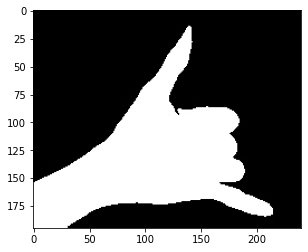

In [14]:
img = images[0] # warning: this is a uint8
plt.imshow(img, cmap=plt.cm.gray)

from sklearn.cluster import KMeans, MiniBatchKMeans

# Perform K Means
K = 100 # begin with 10 (number of gesture labels), increase to much much more as necessary
kmeans = MiniBatchKMeans(n_clusters = K)
kmeans.fit(X_train)

[67 60  0 ... 51 42 81]
(100, 46800)
{0: 7, 1: 6, 2: 2, 3: 0, 4: 2, 5: 8, 6: 0, 7: 9, 8: 8, 9: 8, 10: 3, 11: 5, 12: 5, 13: 3, 14: 1, 15: 0, 16: 6, 17: 0, 18: 8, 19: 4, 20: 3, 21: 7, 22: 3, 23: 0, 24: 8, 25: 5, 26: 0, 27: 2, 28: 1, 29: 4, 30: 9, 31: 7, 32: 3, 33: 9, 34: 7, 35: 7, 36: 8, 37: 6, 38: 6, 39: 0, 40: 8, 41: 6, 42: 6, 43: 5, 44: 3, 45: 0, 46: 3, 47: 0, 48: 4, 49: 5, 50: 7, 51: 1, 52: 8, 53: 8, 54: 7, 55: 8, 56: 3, 57: 4, 58: 0, 59: 4, 60: 6, 61: 1, 62: 7, 63: 2, 64: 2, 65: 0, 66: 5, 67: 5, 68: 8, 69: 2, 70: 4, 71: 8, 72: 9, 73: 5, 74: 9, 75: 1, 76: 0, 77: 8, 78: 6, 79: 6, 80: 2, 81: 5, 82: 2, 83: 6, 84: 0, 85: 6, 86: 2, 87: 7, 88: 0, 89: 9, 90: 2, 91: 3, 92: 1, 93: 9, 94: 1, 95: 3, 96: 9, 97: 2, 98: 8, 99: 4}


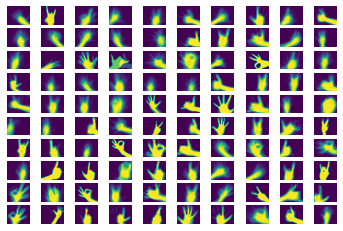

In [15]:
print(kmeans.labels_) # cluster labels for each training image
print(kmeans.cluster_centers_.shape) # K clusters x 46800 pixels

def visualize_all_clusters(kmeans):
    fig=plt.figure()
    columns = 10
    rows = 10

    for i in range(1, columns*rows + 1):
        center = kmeans.cluster_centers_[i-1].reshape((img_shape))
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(center)

# for each KMeans cluster, get the most probable label
# return mapping from cluster to label
def cluster_to_index(cluster_labels, y_train):
    index_labels = {}
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        index_labels[i] = num
    return index_labels

CLUSTERS_TO_INDEX = cluster_to_index(kmeans.labels_, y_train)
print(CLUSTERS_TO_INDEX)

visualize_all_clusters(kmeans)

In [16]:
# Get test results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cluster_ids = kmeans.predict(X_test)
y_pred = np.vectorize(CLUSTERS_TO_INDEX.get)(cluster_ids)

print('Accuracy:',  accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('Recall:',    recall_score(y_test, y_pred, average='micro'))
print('F1:',        f1_score(y_test, y_pred, average='micro'))

Accuracy: 0.49523204068658616
Precision: 0.49523204068658616
Recall: 0.49523204068658616
F1: 0.49523204068658616


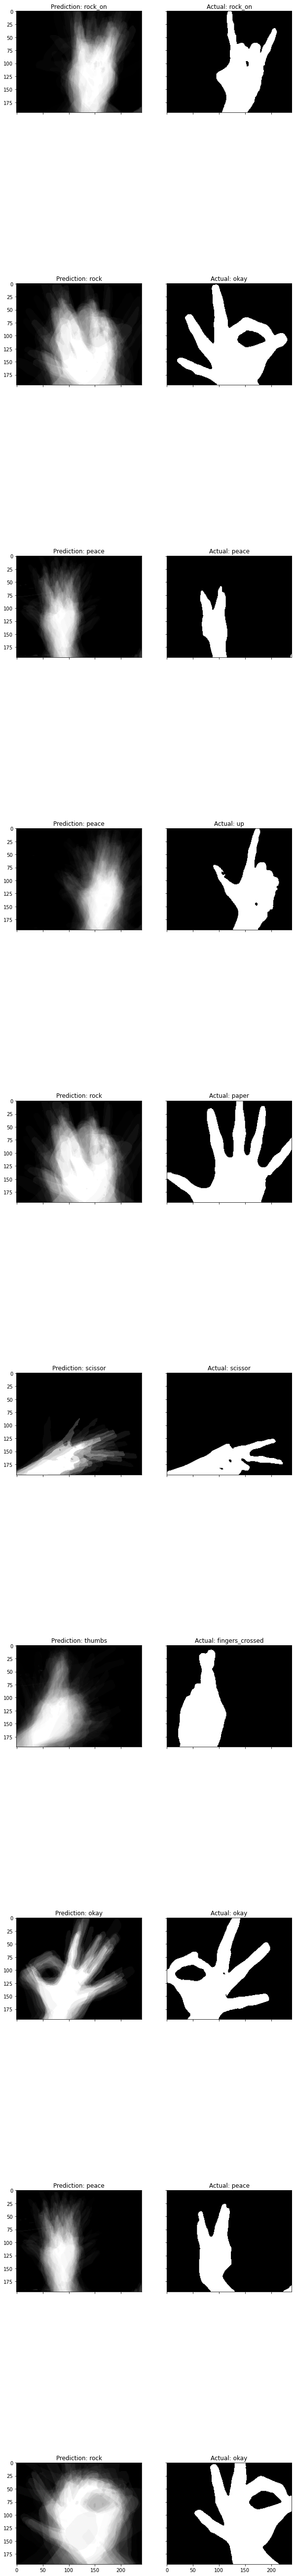

In [17]:
# take 10 test images, predict them, and display them
N = 10
fig, axs = plt.subplots(N, 2, sharex='all', sharey='all', figsize=(10, 10*N))

imgs = X_test[:N]
cluster_ids = kmeans.predict(imgs) # cluster index

for i in range(N):
    img = imgs[i]
    cluster_id = cluster_ids[i]
    cluster = kmeans.cluster_centers_[cluster_id].reshape((img_shape)) # cluster image

    true_label = INDEX_TO_LABELS[y_test[i]]
    pred_label = INDEX_TO_LABELS[CLUSTERS_TO_INDEX[cluster_id]]

    axs[i, 0].imshow(cluster, cmap=plt.cm.gray)
    axs[i, 0].set_title('Prediction: {}'.format(pred_label))

    axs[i, 1].imshow(img.reshape((img_shape)), cmap=plt.cm.gray)
    axs[i, 1].set_title('Actual: {}'.format(true_label))

# Prediction using Random Forest

In [18]:
def resize_image(image_array, target_size=(32, 32)):
    image = Image.fromarray(image_array)
    return np.array(image.resize(target_size, Image.ANTIALIAS))

resized_images = [resize_image(img) for img in images]
resized_images_array = np.array(resized_images)

In [19]:
X = resized_images_array.reshape(resized_images_array.shape[0], -1)
X = standardized_scalar.fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
y_pred = rf_classifier.predict(X_test)

In [23]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       155
           1       0.83      0.92      0.87       149
           2       0.88      0.83      0.85       152
           3       0.87      0.76      0.81       164
           4       0.78      0.87      0.82       148
           5       0.91      0.87      0.89       159
           6       0.93      0.95      0.94       151
           7       0.85      0.83      0.84       157
           8       0.93      0.95      0.94       176
           9       0.96      0.91      0.94       162

    accuracy                           0.88      1573
   macro avg       0.88      0.88      0.88      1573
weighted avg       0.88      0.88      0.88      1573

Confusion Matrix:
 [[144   0   1   1   0   0   0   3   6   0]
 [  0 137   0   0   8   1   1   2   0   0]
 [  1   0 126  12   2   3   0   4   1   3]
 [  1   0  15 125   8   5   3   3   2   2]
 [  0   7   0   3 129   0 

# Prediction using Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# X = resized_images_array.reshape(resized_images_array.shape[0], -1)
X = principal_components
X = standardized_scalar.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
clf.fit(X_train, y_train) # takes 6 min!

y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Prediction using SVM

In [ ]:
components_num = 908
pca = decomposition.PCA(n_components = components_num)
principal_components = pca.fit_transform(standardized_data)
X_train, X_test, y_train, y_test = train_test_split(principal_components, y, test_size=0.3, random_state=0)

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))